## Data generators/processors: determine which call of your processor takes the most time. Which 3 methods are called the most or needed the most time and how much time?

In [1]:
!pip install kafka-python
!pip install snakeviz

In [2]:
from kafka import KafkaConsumer, KafkaProducer
import json
import uuid
import random
import time
import cProfile
import os
import io
import pstats
from pstats import SortKey

In [3]:
servers= ['broker1:9093', 'broker2:9094', 'broker3:9095']
topic = "products"

consumer = KafkaConsumer(
    topic, 
    auto_offset_reset='earliest',
    bootstrap_servers=servers, 
    api_version=(0, 10), 
    value_deserializer = json.loads,
    consumer_timeout_ms=1000
)

In [4]:
def write_json_to_file(filepath, content):
    with open(filepath, "w") as file:
        json.dump(content, file)


def fibonacci(n):
    """Computes the nth-fibonacci number. It is used to create artificially longer runtime for the processor"""
    if n <= 1:
        return 1
    return fibonacci(n-1) + fibonacci(n-2)


def process_data(consumer):
    """Reads the messages, computes the nth-fibonacci number and manipulates the data structure"""
    output = []
    n = 0
    try:
        for n_message, msg in enumerate(consumer, 1):
            # if n_message >= 20:
            #     break
            print("n: {}".format(n))
            if n >= 10:
                n = 0
            print("Start consuming message: {}".format(n_message))
            product = msg.value.get("product")
            keys = list(product.keys())
            for key in keys:
                product[key] = fibonacci(n_message)
            n += 1
            output.append(product)
    except:
        print("Interrupt")
        return output
    return output

pr = cProfile.Profile()
pr.enable()

changed_data = process_data(consumer)

write_json_to_file("changed_data.json", changed_data)

pr.disable()
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('tottime')
ps.print_stats()

with open('stats.txt', 'w+') as f:
    f.write(s.getvalue())

n: 0
Start consuming message: 1
n: 1
Start consuming message: 2
n: 2
Start consuming message: 3
n: 3
Start consuming message: 4
n: 4
Start consuming message: 5
n: 5
Start consuming message: 6
n: 6
Start consuming message: 7
n: 7
Start consuming message: 8
n: 8
Start consuming message: 9
n: 9
Start consuming message: 10
n: 10
Start consuming message: 11
n: 1
Start consuming message: 12
n: 2
Start consuming message: 13
n: 3
Start consuming message: 14
n: 4
Start consuming message: 15
n: 5
Start consuming message: 16
n: 6
Start consuming message: 17
n: 7
Start consuming message: 18
n: 8
Start consuming message: 19
n: 9
Start consuming message: 20
n: 10
Start consuming message: 21
n: 1
Start consuming message: 22
n: 2
Start consuming message: 23
n: 3
Start consuming message: 24
n: 4
Start consuming message: 25
n: 5
Start consuming message: 26
n: 6
Start consuming message: 27
n: 7
Start consuming message: 28
n: 8
Start consuming message: 29
n: 9
Start consuming message: 30


In [5]:
# read stats.txt with pandas
import pandas as pd
df = pd.read_csv('stats.txt', sep='\s+\s+', skiprows=5, header=None, error_bad_lines=False)
df.columns = ['ncalls', 'tottime', 'percall', 'cumtime', 'percall filename:lineno(function)']
df.head()

/tmp/ipykernel_290/2154001296.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('stats.txt', sep='\s+\s+', skiprows=5, header=None, error_bad_lines=False)
/tmp/ipykernel_290/2154001296.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('stats.txt', sep='\s+\s+', skiprows=5, header=None, error_bad_lines=False)


,ncalls,tottime,percall,cumtime,percall filename:lineno(function)
0,77540342/330,17.617,0.000,17.617,0.053 /tmp/ipykernel_290/630567185.py:6(fibona...
1,18,1.058,0.059,1.058,0.059 {method 'poll' of 'select.epoll' objects}
2,1,0.101,0.101,0.101,0.101 {built-in method time.sleep}
3,1,0.022,0.022,0.022,0.022 {built-in method io.open}
4,30,0.003,0.000,0.003,0.000 /opt/conda/lib/python3.10/json/decoder.p...


In [6]:
df['percall filename:lineno(function)'].str.split('\s+', expand=True).iloc[:, 1:].values

df['function'] = [''.join(str(x)) for x in df['percall filename:lineno(function)'].str.split('\s+', expand=True).iloc[:, 1:].values]

In [7]:
# remove all special chars from column function except char /
df['function'] = df['function'].str.replace('[^\w\s/]', '')
df.head()
# remove None string from function column
df['function'] = df['function'].str.replace('None','')
df.head()

/tmp/ipykernel_290/2192852116.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['function'] = df['function'].str.replace('[^\w\s/]', '')


,ncalls,tottime,percall,cumtime,percall filename:lineno(function),function
0,77540342/330,17.617,0.000,17.617,0.053 /tmp/ipykernel_290/630567185.py:6(fibona...,/tmp/ipykernel_290/630567185py6fibonacci \n
1,18,1.058,0.059,1.058,0.059 {method 'poll' of 'select.epoll' objects},method poll of selectepoll objects
2,1,0.101,0.101,0.101,0.101 {built-in method time.sleep},builtin method timesleep
3,1,0.022,0.022,0.022,0.022 {built-in method io.open},builtin method ioopen
4,30,0.003,0.000,0.003,0.000 /opt/conda/lib/python3.10/json/decoder.p...,/opt/conda/lib/python310/json/decoderpy343raw_...


In [8]:
df['percall'] = df['percall filename:lineno(function)'].str.split('\s+', expand=True)[0]

In [9]:
df.head()
#drop percall filename:lineno(function)
df.drop(columns=['percall filename:lineno(function)'], inplace=True)
df.head()

,ncalls,tottime,percall,cumtime,function
0,77540342/330,17.617,0.053,17.617,/tmp/ipykernel_290/630567185py6fibonacci \n
1,18,1.058,0.059,1.058,method poll of selectepoll objects
2,1,0.101,0.101,0.101,builtin method timesleep
3,1,0.022,0.022,0.022,builtin method ioopen
4,30,0.003,0.000,0.003,/opt/conda/lib/python310/json/decoderpy343raw_...


<Axes: xlabel='function'>

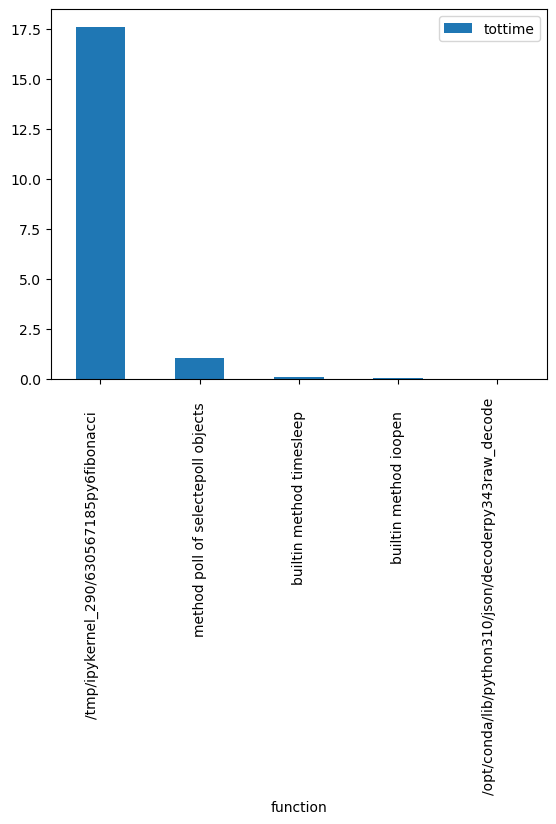

In [10]:
#plot only 5 highest tottime
df.sort_values(by=['tottime'], ascending=False).head(5).plot.bar(x='function', y='tottime')